In [26]:
from ultralytics import YOLO
import os

actual_path = os.path.abspath(os.getcwd())
model_path=actual_path+'/models/get-plate-model.pt'
model=YOLO(model_path)
source_image=actual_path+'/testing/Importar-coche-a-Espana-1200x675.jpg'
print(source_image)
"""
images=[
    'data/val/images/ba2b2dbd-captura_20250318-161749.png',
    'data/val/images/be627c47-captura_20250318-161845.png'
]
"""
results = model.predict(
    source=source_image,
    conf=0.25,
    save=False,
    verbose=False
)

/home/david/Escritorio/programacion/parking/testing/Importar-coche-a-Espana-1200x675.jpg


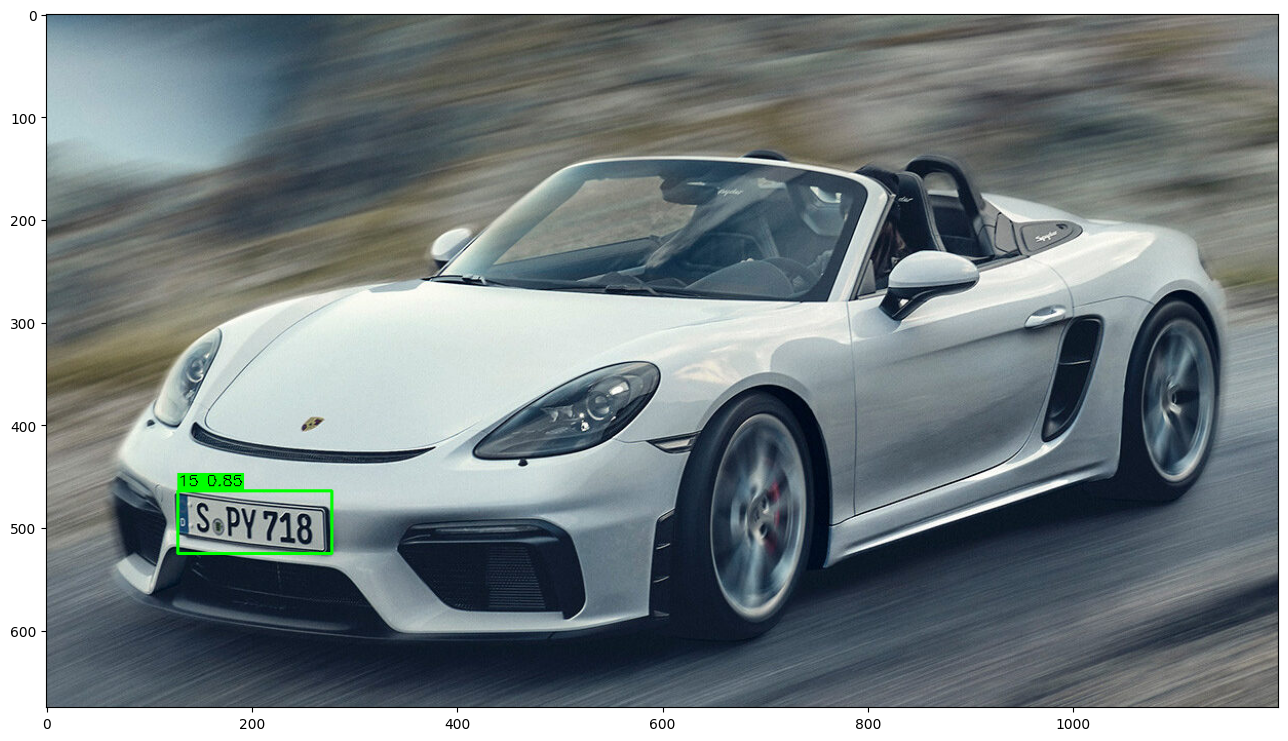

In [27]:
import cv2 
import matplotlib.pyplot as plt

orig_img=cv2.imread(source_image)
orig_img=cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

predictions = results[0]
highest_conf = 0

for box in predictions.boxes:
    conf = float(box.conf[0])
    if conf > highest_conf:
        highest_conf = conf
        plate_box = box


x1, y1, x2, y2 = plate_box.xyxy[0]

# Convertir a int para dibujar con OpenCV
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    #print(x1, y1, x2, y2)

# ID de la clase detectada
cls_id = int(plate_box.cls[0])

# Confianza de la detección
conf = float(plate_box.conf[0])

# Nombre de la clase (basado en model.names)
class_name = model.names[cls_id] if model.names and cls_id < len(model.names) else f"cls_{cls_id}"

#print(f"Clase: {class_name}, confianza: {conf:.2f}")
# Dibujo del rectángulo
color = (0, 255, 0)  # Verde
thickness = 2
cv2.rectangle(orig_img, (x1, y1), (x2, y2), color, thickness)

# Texto (etiqueta + confianza)
label = f"{class_name} {conf:.2f}"
# Para dibujar el fondo del texto (opcional, para que sea legible)
(tw, th), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
# Caja para el texto encima del bounding plate_box
cv2.rectangle(orig_img, (x1, y1 - th - baseline), (x1 + tw, y1), color, -1)
cv2.putText(orig_img, label, (x1, y1 - baseline),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

plt.figure(figsize=(16, 9))
plt.imshow(orig_img)
plt.show()

True

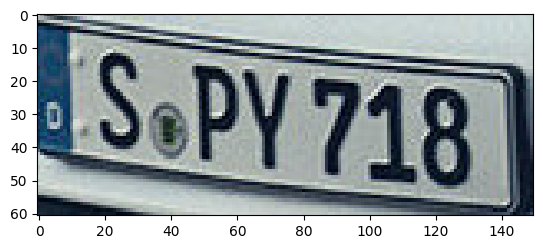

In [28]:
img_NZ_bgr = cv2.imread(source_image, cv2.IMREAD_COLOR)
img_NZ_rgb = img_NZ_bgr[:, :, ::-1]   # a RGB

plate_original = img_NZ_rgb[y1:y2,x1:x2].copy()
plt.imshow(plate_original)
cv2.imwrite(actual_path+'/testing/new_plate.png',plate_original)


In [29]:
model_path = actual_path+'/models/slice-plates.pt'

model=YOLO(model_path)
"""
images=[
    'data/val/images/ba2b2dbd-captura_20250318-161749.png',
    'data/val/images/be627c47-captura_20250318-161845.png'
]
"""
results = model.predict(
    source=plate_original,
    conf=0.25,    # Umbral de confianza
    save=False,   # No que dibuje YOLO; lo haremos manualmente con OpenCV
    verbose=False
)

6
16 9 32 41
Clase: S, confianza: 0.92
46 14 62 44
Clase: P, confianza: 0.94
61 15 78 47
Clase: Y, confianza: 0.95
81 17 98 49
Clase: 7, confianza: 0.85
97 19 115 51
Clase: 1, confianza: 0.91
113 19 132 52
Clase: 8, confianza: 0.89


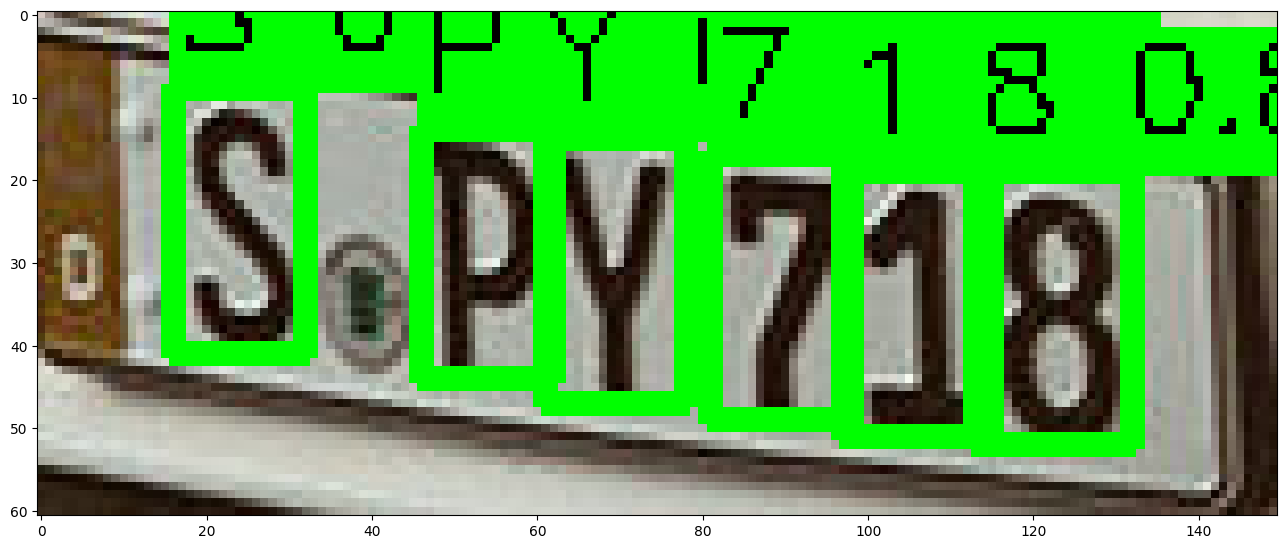

In [ ]:
orig_img=cv2.cvtColor(plate_original, cv2.COLOR_BGR2RGB)

predictions = results[0]
sorted_boxes = sorted(predictions.boxes, key=lambda box: box.xyxy[0][0])
print(len(predictions))
matricula_predecida= ""
for plate_box in sorted_boxes:
    x1, y1, x2, y2 = plate_box.xyxy[0]

    # Convertir a int para dibujar con OpenCV
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    print(x1, y1, x2, y2)

    # ID de la clase detectada
    cls_id = int(plate_box.cls[0])

    # Confianza de la detección
    conf = float(plate_box.conf[0])

    # Nombre de la clase (basado en model.names)
    class_name = model.names[cls_id] if model.names and cls_id < len(model.names) else f"cls_{cls_id}"

    matricula_predecida += class_name
    print(f"Clase: {class_name}, confianza: {conf:.2f}")
    # Dibujo del rectángulo
    color = (0, 255, 0)  # Verde
    thickness = 2
    cv2.rectangle(orig_img, (x1, y1), (x2, y2), color, thickness)

    # Texto (etiqueta + confianza)
    label = f"{class_name} {conf:.2f}"
    # Para dibujar el fondo del texto (opcional, para que sea legible)
    (tw, th), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    # Caja para el texto encima del bounding plate_box
    cv2.rectangle(orig_img, (x1, y1 - th - baseline), (x1 + tw, y1), color, -1)
    cv2.putText(orig_img, label, (x1, y1 - baseline),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

plt.figure(figsize=(16, 9))
plt.imshow(orig_img)
plt.show()
print(matricula_predecida)

Text(0.5, 1.0, 'Black and White Image')

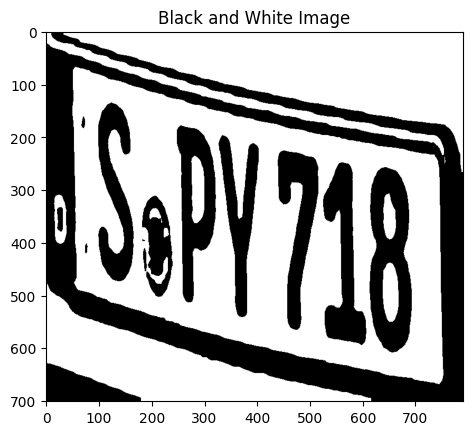

In [32]:
import numpy as np
height, width = plate_original.shape[:2]

plate_original = cv2.imread(actual_path+'/testing/new_plate.png',plate_original)
plate = cv2.resize(plate_original, (width+640, height+640))

img_gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
(thresh, im_bw) = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

thresh = 127
img_bw = cv2.threshold(img_gray, thresh, 255, cv2.THRESH_BINARY)[1]

#kernel = np.ones((3, 3), np.uint8)
#img_bw = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, kernel)

#img_bw = cv2.erode(img_bw,kernel,iterations = 1)

plt.imshow(img_bw, cmap="gray");plt.title("Black and White Image")